In [1]:
import numpy as np
from geoist.inversion import abic
from geoist.others import utils
import matplotlib.pyplot as plt


In [2]:
import os
import pathlib
from datetime import datetime
from functools import wraps
from pathos.multiprocessing import Pool
import numpy as np
from scipy import linalg as splin
from scipy import sparse as spsparse
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import h5py

import cupy as cp

from geoist import gridder
from geoist.pfm import prism
from geoist.inversion.mesh import PrismMesh
from geoist.inversion import walsh
from geoist.inversion import toeplitz as tptz
from geoist.others import utils
from geoist.inversion import abic 

## Structure of smooth constraint

Suppose unkowns are arrange in the order: first along x-axis, then along y-axis, then along z-axis. The vector of unkowns will have shape (nz,ny,nx). 
Under such assumption, we get smooth constraints as follows.
### Along x-axis
The constraint alone x-axis is built by a 3 level hierarchical structure. The smallest structure correspond to one line along x-axis, for example, the 1-st order smooth constraint would be $$ A^{(n_x-1) \times n_x} = \begin{bmatrix} 1 & -1 & 0 & \dots & 0 \\ 0 & 1 & -1 & \dots & \vdots \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 0 & \dots & 0 & 1 & -1 \end{bmatrix}$$
The 2-nd level correspond to one layer and is built by $A$ in the form of $$ B^{n_y \times n_y} = \begin{bmatrix} A & 0 & \dots & 0 \\ 0&A &\dots & \vdots \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & A\end{bmatrix}$$
The 3-rd level correspond to the whole grid and is built by $B$ in the form of $$ C^{n_z \times n_z} = \begin{bmatrix} B & 0 & \dots & 0 \\ 0&B &\dots & \vdots \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots &B\end{bmatrix}$$

Using these formulas, we get $$C^TC = \begin{bmatrix} B^TB & 0 & \dots & 0 \\ 0&B^TB &\dots & \vdots \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots &B^TB\end{bmatrix}$$

$$B^TB = \begin{bmatrix} A^TA & 0 & \dots & 0 \\ 0&A^TA &\dots & \vdots \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots &A^TA\end{bmatrix}$$

$$A^TA = \begin{bmatrix}1& -1& 0 & \dots & 0 \\ -1 & 2 & -1 & 0 & \vdots \\ 0 & \ddots & \ddots & \ddots & \vdots \\ \vdots & \ddots & -1 & 2 & -1 \\ 0 & 0 & \dots & -1 & 1\end{bmatrix}$$

### Along y-axis
The constraint alone y-axis is built by a 2 level hierarchical structure. The smallest structure correspond to one layer, for example, the 1-st order smooth constraint would be $$ A^{(n_y-1)n_x \,\times \,n_xn_y} = \begin{bmatrix} 1 & 0 & \dots & -1 & 0 & \dots & 0 \\ 0 & 1 & 0 & \ddots  & -1 & \ddots & \vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\ 0 & 0& \dots &1  & 0 & \dots & -1 \end{bmatrix}$$
There are $n_x -1$ zeros between $1$ and $-1$ in each line.

The 2-nd level correspond to one layer and is built by $A$ in the form of $$ B^{n_z \times n_z} = \begin{bmatrix} A & 0 & \dots & 0 \\ 0&A &\dots & \vdots \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & A\end{bmatrix}$$

Using these formulas, we get $$B^TB = \begin{bmatrix} A^TA & 0 & \dots & 0 \\ 0&A^TA &\dots & \vdots \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots &A^TA\end{bmatrix}$$

$$A^TA = \begin{bmatrix}1& 0 &\dots & -1& 0 & \dots & \dots & \dots&\dots & 0 \\ 0 & \ddots & \ddots & \ddots &\ddots  &\ddots &\ddots&\ddots&\ddots&\vdots \\ \vdots & \ddots & 1 & \ddots & \ddots  &\ddots&\ddots&\ddots&\ddots  & \vdots \\ -1 & \ddots & \ddots & 2 & \ddots & \ddots &\ddots&\ddots&\ddots& \vdots \\ 0 & \ddots & \ddots & \ddots & \ddots & \ddots &\ddots&\ddots&\ddots&\vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & 2 &\ddots&\ddots&\ddots&\vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots &1&\ddots&\ddots&-1 \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots &\ddots&\ddots&\ddots&0\\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots &\ddots&\ddots&\ddots&\vdots\\ 0 & \dots & \dots & \dots & \dots & \dots &-1&0&\dots&1\end{bmatrix}$$
There are $n_x -1$ zeros between $1$ and $-1$ in the first row and first column.

### Along z-axis
The constraint alone z-axis only have one level, which correspond to the whole grid. The 1-st order smooth constraint would be $$ A^{(n_xn_y-1)n_z \,\times \,n_xn_yn_z} = \begin{bmatrix} 1 & 0 & \dots & -1 & 0 & \dots & 0 \\ 0 & 1 & 0 & \ddots  & -1 & \ddots & \vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\ 0 & 0& \dots &1  & 0 & \dots & -1 \end{bmatrix}$$
There are $n_xn_y -1$ zeros between $1$ and $-1$ in each line.

$$A^TA = \begin{bmatrix}1& 0 &\dots & -1& 0 & \dots & \dots & \dots&\dots & 0 \\ 0 & \ddots & \ddots & \ddots &\ddots  &\ddots &\ddots&\ddots&\ddots&\vdots \\ \vdots & \ddots & 1 & \ddots & \ddots  &\ddots&\ddots&\ddots&\ddots  & \vdots \\ -1 & \ddots & \ddots & 2 & \ddots & \ddots &\ddots&\ddots&\ddots& \vdots \\ 0 & \ddots & \ddots & \ddots & \ddots & \ddots &\ddots&\ddots&\ddots&\vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & 2 &\ddots&\ddots&\ddots&\vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots &1&\ddots&\ddots&-1 \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots &\ddots&\ddots&\ddots&0\\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots &\ddots&\ddots&\ddots&\vdots\\ 0 & \dots & \dots & \dots & \dots & \dots &-1&0&\dots&1\end{bmatrix}$$
There are $n_xn_y -1$ zeros between $1$ and $-1$ in the first row and first column.



## Derivatives in ABIC calculation

### Derivatives of sums of determinates
Let $A_i$ are $m\times m$ matrices, $a_i$ are variables, consider function $f(a_1,a_2,...,a_n) = \log \det(\sum_i a_i A_i)$. We want $\partial f/\partial a_i$.

According to Jacobi's formula:
$$\frac{d \det(A(t))}{dt} = \det(A(t))\mathrm{Tr}\left(A(t)^{-1}\frac{dA}{dt}\right)$$

We get:
$$\begin{array}{rl}\frac{\partial f}{\partial a_j} =& \frac{1}{\det(\sum_i a_i A_i)}\det(\sum_i a_i A_i) \mathrm{Tr}\left((\sum_i a_i A_i)^{-1}\frac{d \sum_i a_i A_i}{d a_j}\right) \\
= &\mathrm{Tr}\left((\sum_i a_i A_i)^{-1} A_j\right) \end{array}$$

If $A_i = B_i^T \begin{bmatrix}w_0 & 0 & \cdots & 0 \\ 0 & w_1 & \ddots & \vdots \\ \vdots & \ddots & \ddots & \vdots \\ 0 & \cdots & 0 & w_{n-1} \end{bmatrix} B_i$, where $B_i = \begin{bmatrix} b_0 \\ b_1 \\ \vdots \\ b_{n-1} \end{bmatrix}$, then

$$\frac{\partial f}{\partial w_j} = \mathrm{Tr}\left((\sum_i a_i A_i)^{-1} b_j^T b_j\right)$$

### Derivatives of min_U
In our problem, U is:

$$U = \frac{1}{2}||(a_g G^T obs + \sum a_i B_i^T constraint_i) - (a_g G^T G + \sum a_i B_i^TB_i)m||^2$$

Solve the least square problem and get it's solution $m_{opt}$, then

$$\min(U) = \frac{1}{2}||(a_g G^T obs + \sum a_i B_i^T constraint_i) - (a_g G^T G + \sum a_i B_i^TB_i)m_{opt}||^2$$

Denote $G=B_0$, $obs = constraint_0$ and $B_i constraint_i = r_i$for abbreavity:

$$\min(U) = \frac{1}{2}||\sum a_i B_i^T constraint_i - \sum a_i B_i^TB_i m_{opt}||^2$$

After some simple algebra operations, we get

$$\frac{\partial \min(U)}{\partial a_i} = (\sum a_j r_j)^T + (\sum a_j B_j^T B_j m_{opt})$$

In [3]:
print_level = -1 # control indentation of prints.
last_print_level = -2
mat_count = 0

# define model volume and grid shape
nzyx = [32,8,64]
source_volume = [-47500, 47500, -47500, 47500, 4000, 32000]

model_density = np.zeros(tuple(nzyx))
for iz in range(20):
    model_density[iz,:,35-iz:55-iz] = 1.0

refer_density = np.zeros(tuple(nzyx))
refer_density[:,:,35:45] = model_density[:,:,35:45]

# reference constraint on each cell
refer_constraint = np.zeros_like(refer_density)
refer_constraint[np.where(refer_density != 0.)] = 1.

# depth constraint
step = (source_volume[5] - source_volume[4])/nzyx[0]
depths = np.linspace(source_volume[4]+step/2.,source_volume[5]-step/2.,nzyx[0])
depth0 = 0
alpha = 1
depth_constraint = depths[0]**alpha/(depths+depth0)**alpha
#depth_constraint = np.ones(nzyx[0])

weights = {'dx':23.54,'dy':860.,'dz':60.28,'depth':1.,'obs':1.69,'refers':[0.67],'bound':1.0}

small_model = abic.GravInvAbicModel(nzyx=nzyx,
                       source_volume=source_volume,
                       model_density=model_density,
                       refer_densities=[refer_density],
                       depth_constraint=depth_constraint,
                       weights=weights,
                       smooth_on='m',
                       data_dir = 'E:\changning\data\gravity_inversion'
                       )
small_model.gpu_id = 2
#small_model.constraints['refer'] = refer_constraint.ravel()
small_model.gen_model_name()
small_model.gen_mesh()
small_model.gen_kernel()
small_model.forward()
small_model.min_density = 0.
small_model.max_density = 1.
orig_obs = small_model.obs_data.copy()
#small_model.obs_data += np.random.randn(*small_model.obs_data.shape)*np.max(np.abs(small_model.obs_data))*0.01
small_model.walsh_transform()
#small_model.do_linear_solve()
#small_model.abic_optimize()
#small_model.lasso_optimize()
#small_model.calc_abic()
#%time small_model.bound_optimize()
#recovered = (small_model.kernel_op.gtoep.matvec(small_model.solution.ravel()).reshape(nzyx[1],nzyx[2]))
res = (recovered - small_model.obs_data.reshape(nzyx[1],nzyx[2]))
#print(np.linalg.norm(res)**2)
#print(np.linalg.norm(small_model.solution.ravel()-refer_density.ravel())**2)
#small_model.calc_res()
#small_model.print_summary()

calling forward
forward completed in 0:00:00.002993

calling walsh_transform
generating walsh_matrix
walsh transformation of kernel already exists.
walsh transformation of depth already exists.
walsh transformation of refers already exists.
walsh transformation of dy already exists.
walsh transformation of dz already exists.
walsh transformation of dx already exists.
walsh_transform completed in 0:00:00.075419


In [4]:
small_model.abic_val

0

In [5]:
list(small_model._weights.keys())

['dx', 'dy', 'dz', 'depth', 'obs', 'refers', 'bound']

In [11]:
small_model.do_linear_solve()


calling do_linear_solve
do_linear_solve completed in 0:00:01.805175


In [10]:
small_model.calc_abic()


calling calc_abic
    calling calc_log_obs_det
    calc_log_obs_det completed in 0:00:00.002992

    calling calc_log_prior_total_det
    calc_log_prior_total_det completed in 0:00:59.228710

    calling calc_u
    calc_u completed in 0:00:00.002992
calc_abic completed in 0:00:59.235692


90443.68377390713

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1ee4a4f0>)

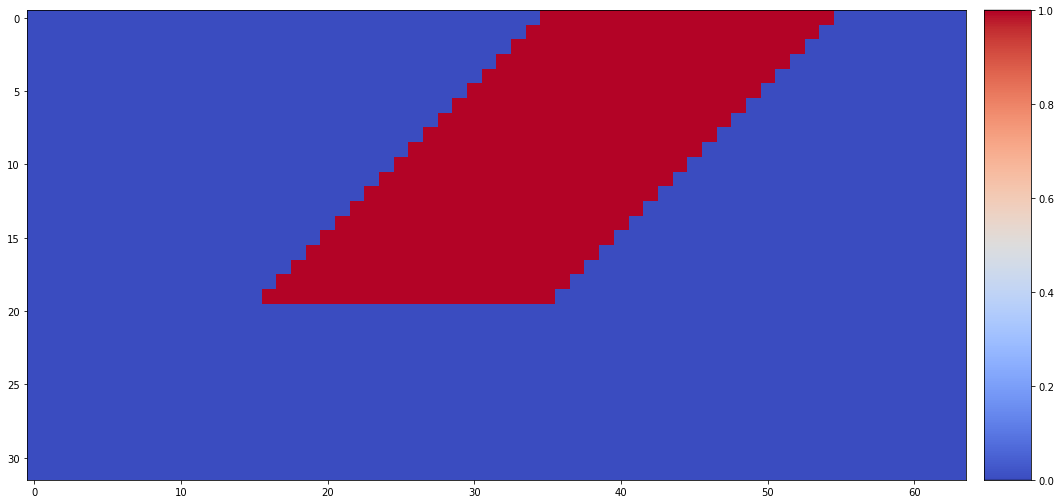

In [14]:
utils.plot_matrix(small_model.model_density.reshape(nzyx)[:,5,:],fname='orig.png')

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1f102580>)

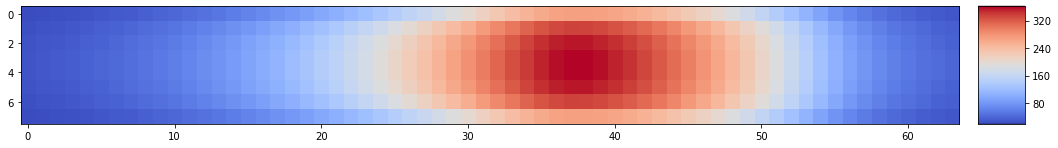

In [16]:
utils.plot_matrix(small_model.obs_data.reshape(nzyx[1],nzyx[2]),fname='bound.png')

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1f392670>)

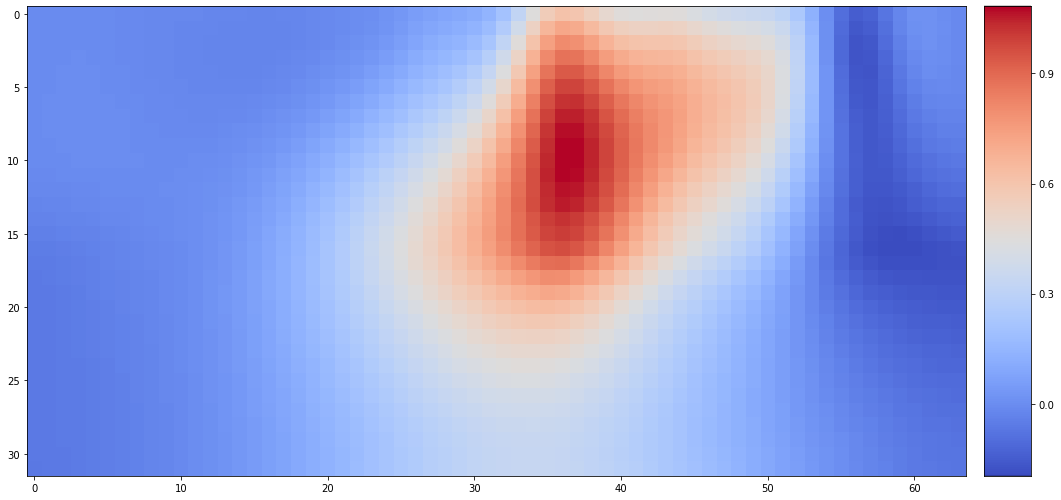

In [17]:
utils.plot_matrix(small_model.solution.reshape(nzyx)[:,5,:],fname='no_bound.png')

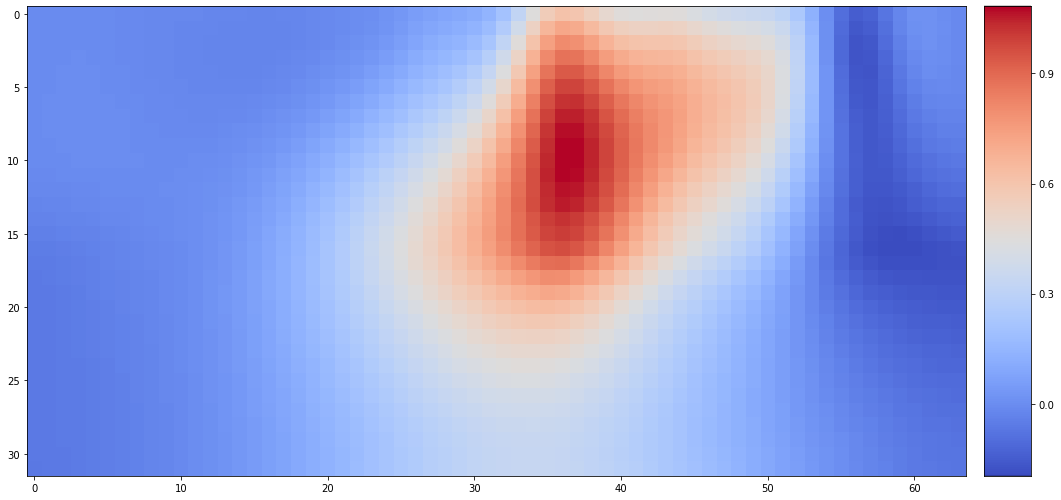

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1f7056d0>)

In [18]:
utils.plot_matrix(small_model.solution.reshape(nzyx)[:,5,:])

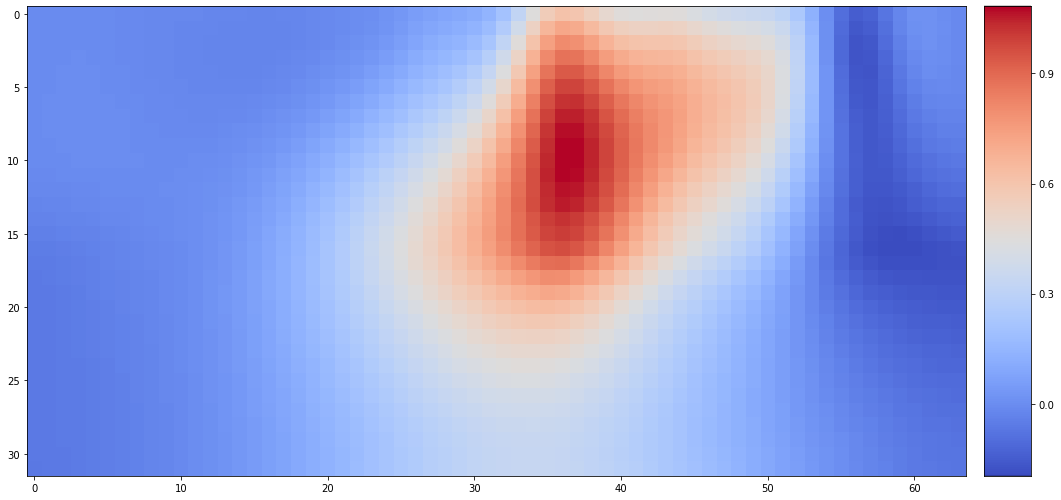

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1f3bcd90>)

In [19]:
utils.plot_matrix(small_model.solution.reshape(nzyx)[:,5,:])

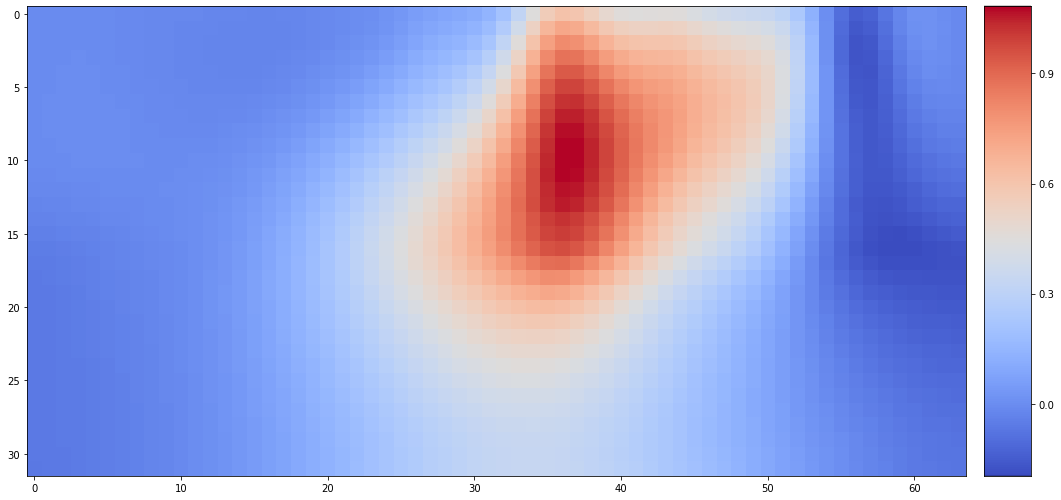

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1fa4d820>)

In [20]:
utils.plot_matrix(small_model.solution.reshape(nzyx)[:,5,:])

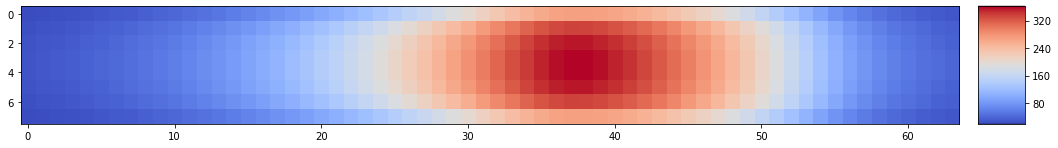

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a1fb58ac0>)

In [21]:
utils.plot_matrix(small_model.obs_data.reshape(small_model.ny,small_model.nx))

In [22]:
utils.plot_matrix(small_model.kernel_op.gtoep.matvec(small_model.bound_solution.x).reshape(nzyx[1],nzyx[2]))

AttributeError: 'GravInvAbicModel' object has no attribute 'bound_solution'

In [ ]:
utils.plot_matrix(small_model.kernel_op.gtoep.matvec(small_model.solution).reshape(nzyx[1],nzyx[2]))

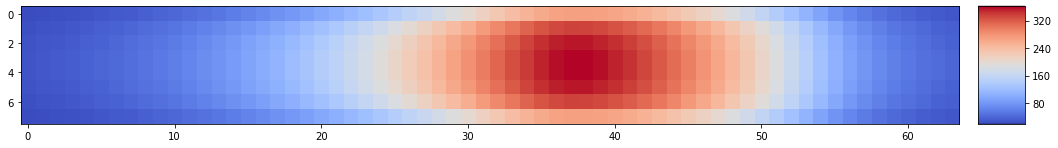

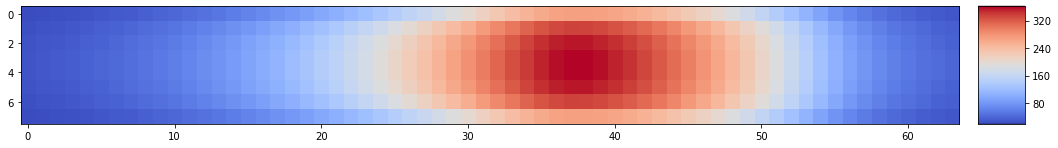

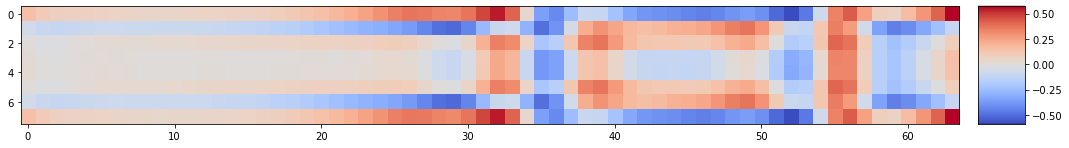

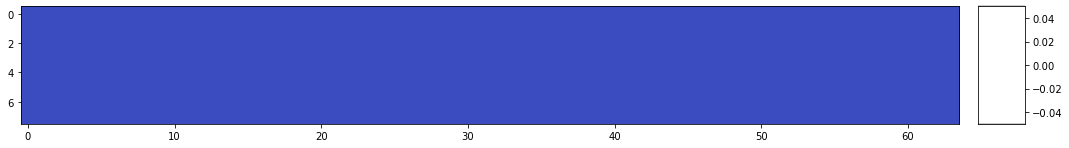

(<Figure size 1296x1296 with 2 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x16a21234610>)

In [28]:

recovered = (small_model.kernel_op.gtoep.matvec(small_model.solution.ravel()).reshape(nzyx[1],nzyx[2]))
res = (recovered - small_model.obs_data.reshape(nzyx[1],nzyx[2]))
utils.plot_matrix(orig_obs.reshape(nzyx[1],nzyx[2]))
utils.plot_matrix(small_model.obs_data.reshape(nzyx[1],nzyx[2]))
utils.plot_matrix(res)
utils.plot_matrix(orig_obs.reshape(nzyx[1],nzyx[2]) - small_model.obs_data.reshape(nzyx[1],nzyx[2]))